In [1]:
import tensorflow as tf
import tensorflow_text as text
import tensorflow_models as tfm
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from official.nlp import optimization  # to create AdamW optimizer
import shutil
import os
import json

C:\Users\Severus\AppData\Roaming\Python\Python39\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\Severus\AppData\Roaming\Python\Python39\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not fi

In [2]:
class CONFIG: 
    EPS = 1e-8 
    EPOCHS = 3 # 3~5
    BATCH_SIZE = 16 # 8, 32
    LEARNING_RATE = 2e-5 # 1e-5
    MAX_LENGTH = 128 # 256
    BERT_MODEL_NAME = 'bert-base-uncased' # large, RoBERTa, DeBERTa
    DEVICE_NAME = "mps" # Cuda or alternative

In [69]:
def load_dataset(path,reladict={}):
    with open(path,'r',encoding='UTF-8') as f:
        data=[json.loads(line) for line in f]
    sent=[]
    relation=[]
    for d in data:
        token=d['token']
        for i in range(d['h']['pos'][0],d['h']['pos'][1]):
            token[i]='[MASK]'
        for i in range(d['t']['pos'][0],d['t']['pos'][1]):
            token[i]='[MASK]'
        sent.append([' '.join(token)])
        if reladict.get(d['relation'],False)==False:
            reladict.setdefault(d['relation'],len(reladict))
        relation.append(reladict[d['relation']])
    temp=np.zeros(shape=(len(relation),len(reladict)))
    print(temp.shape)
    print(reladict)
    for i in range(len(relation)):
        temp[i][relation[i]]=1
    data=tf.data.Dataset.from_tensor_slices((sent,temp)).shuffle(1000).batch(CONFIG.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return data,reladict
    
test_ds,reladict=load_dataset('semeval_test.txt')
valid_ds=load_dataset('semeval_val.txt',reladict)[0]
train_ds=load_dataset('semeval_train.txt',reladict)[0]

(2717, 19)
{'Message-Topic(e1,e2)': 0, 'Product-Producer(e2,e1)': 1, 'Instrument-Agency(e2,e1)': 2, 'Entity-Destination(e1,e2)': 3, 'Cause-Effect(e2,e1)': 4, 'Component-Whole(e1,e2)': 5, 'Product-Producer(e1,e2)': 6, 'Member-Collection(e2,e1)': 7, 'Other': 8, 'Entity-Origin(e1,e2)': 9, 'Content-Container(e1,e2)': 10, 'Entity-Origin(e2,e1)': 11, 'Cause-Effect(e1,e2)': 12, 'Component-Whole(e2,e1)': 13, 'Content-Container(e2,e1)': 14, 'Instrument-Agency(e1,e2)': 15, 'Message-Topic(e2,e1)': 16, 'Member-Collection(e1,e2)': 17, 'Entity-Destination(e2,e1)': 18}
(1493, 19)
{'Message-Topic(e1,e2)': 0, 'Product-Producer(e2,e1)': 1, 'Instrument-Agency(e2,e1)': 2, 'Entity-Destination(e1,e2)': 3, 'Cause-Effect(e2,e1)': 4, 'Component-Whole(e1,e2)': 5, 'Product-Producer(e1,e2)': 6, 'Member-Collection(e2,e1)': 7, 'Other': 8, 'Entity-Origin(e1,e2)': 9, 'Content-Container(e1,e2)': 10, 'Entity-Origin(e2,e1)': 11, 'Cause-Effect(e1,e2)': 12, 'Component-Whole(e2,e1)': 13, 'Content-Container(e2,e1)': 14, 'In

In [47]:
print(reladict)
print(len(reladict))
invdict={}
for k,v in reladict.items():
    invdict.setdefault(v,k)
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label}')
    print(len(label))

{'Message-Topic(e1,e2)': 0, 'Product-Producer(e2,e1)': 1, 'Instrument-Agency(e2,e1)': 2, 'Entity-Destination(e1,e2)': 3, 'Cause-Effect(e2,e1)': 4, 'Component-Whole(e1,e2)': 5, 'Product-Producer(e1,e2)': 6, 'Member-Collection(e2,e1)': 7, 'Other': 8, 'Entity-Origin(e1,e2)': 9, 'Content-Container(e1,e2)': 10, 'Entity-Origin(e2,e1)': 11, 'Cause-Effect(e1,e2)': 12, 'Component-Whole(e2,e1)': 13, 'Content-Container(e2,e1)': 14, 'Instrument-Agency(e1,e2)': 15, 'Message-Topic(e2,e1)': 16, 'Member-Collection(e1,e2)': 17, 'Entity-Destination(e2,e1)': 18}
19
Review: [b'the [MASK] [MASK] was derived from a macrophage-enriched [MASK] [MASK] .']
Label : [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
19
Review: [b'a [MASK] takes you forward by a more or less fixed number of pages at any given position in the [MASK] .']
Label : [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
19
Review: [b'the [MASK] of the issue was increased from its initial [MASK] of us $ 750 million following 

In [4]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.CategoricalAccuracy()

In [5]:
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * CONFIG.EPOCHS
num_warmup_steps = int(0.1*num_train_steps)

#optimizer=tf.keras.optimizers.Adam(learning_rate=1e4)
optimizer = optimization.create_optimizer(init_lr=CONFIG.LEARNING_RATE,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [6]:
preprocessor = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_layer=hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3', name='BERT_encoder',trainable=True)

In [7]:
class MaskingLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(MaskingLayer, self).__init__(**kwargs)
    def call(self, inputs):
        #return inputs[0]
        return {'input_word_ids':inputs[0]['input_word_ids'],'input_type_ids':tf.math.add(inputs[0]['input_type_ids'],inputs[1]),'input_mask':tf.math.add(inputs[0]['input_mask'],tf.math.multiply(inputs[1],-1))}

def build_classifier_model(output_shape):
    #position_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='mask')
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = preprocessor
    #masklayer = MaskingLayer()
    encoder_inputs = preprocessing_layer(text_input)
    #encoder_inputs = masklayer([encoder_inputs,position_input])
    encoder = bert_layer
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(output_shape, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [48]:
text_test=['this is such an amazing movie!']
model = build_classifier_model(len(reladict))
tf.keras.utils.plot_model(model)
print(model.summary())
bert_raw_result = model([tf.constant(text_test)])
print(tf.sigmoid(bert_raw_result))

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_ma

In [49]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
history=model.fit(train_ds,validation_data=valid_ds,verbose=1,epochs=CONFIG.EPOCHS)

Epoch 1/3


407/407 [==============================] - 113s 263ms/step - loss: 1.1793 - categorical_accuracy: 0.6902 - val_loss: 1.8837 - val_categorical_accuracy: 0.5713
Epoch 2/3
407/407 [==============================] - 106s 261ms/step - loss: 0.9707 - categorical_accuracy: 0.7221 - val_loss: 1.4226 - val_categorical_accuracy: 0.6343
Epoch 3/3
407/407 [==============================] - 107s 263ms/step - loss: 1.3779 - categorical_accuracy: 0.6199 - val_loss: 1.4226 - val_categorical_accuracy: 0.6343


In [51]:
print(history.history)

{'loss': [1.1793009042739868, 0.9707120656967163, 1.3778924942016602], 'categorical_accuracy': [0.6901798248291016, 0.7221453785896301, 0.6199477314949036], 'val_loss': [1.883694052696228, 1.422611951828003, 1.422612190246582], 'val_categorical_accuracy': [0.5713328719139099, 0.6342933773994446, 0.6342933773994446]}


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


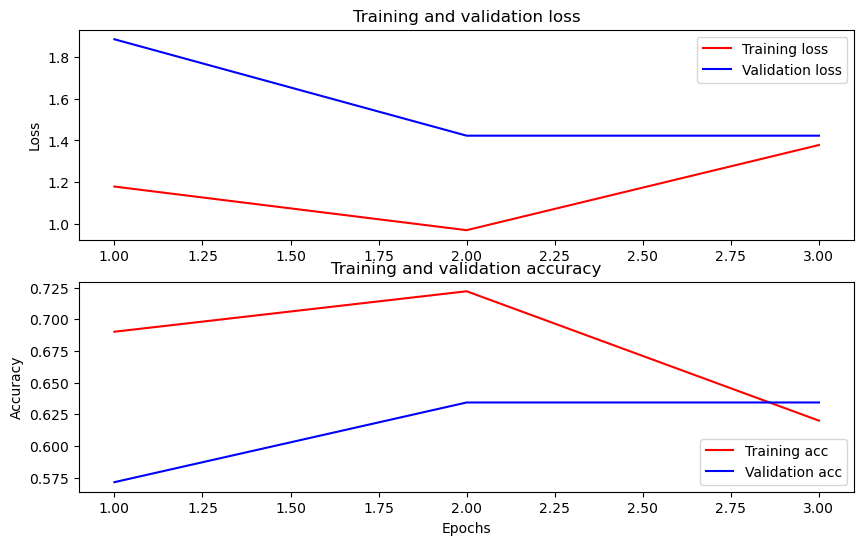

In [53]:
history_dict = history.history
print(history_dict.keys())

loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']

fig = plt.figure(figsize=(10, 6))
fig.tight_layout()
epochs = range(1, len(acc) + 1)
plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
# b is for "solid blue line"
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [54]:
model.evaluate(test_ds)

170/170 [==============================] - 11s 66ms/step - loss: 1.3822 - categorical_accuracy: 0.6408


[1.382184386253357, 0.6407802700996399]

In [67]:
for tokens,labels in test_ds.take(1):
    res=model.predict(tokens)
    for i in range(len(res)):
        print(invdict[res[i].argmax()],invdict[labels.numpy()[i].tolist().index(1)])
    break


1/1 [==============================] - 0s 97ms/step
Entity-Destination(e1,e2) Entity-Destination(e1,e2)
Message-Topic(e1,e2) Message-Topic(e1,e2)
Entity-Destination(e1,e2) Entity-Destination(e1,e2)
Product-Producer(e2,e1) Product-Producer(e2,e1)
Message-Topic(e1,e2) Message-Topic(e1,e2)
Product-Producer(e2,e1) Product-Producer(e2,e1)
Entity-Destination(e1,e2) Entity-Destination(e1,e2)
Cause-Effect(e2,e1) Cause-Effect(e2,e1)
Entity-Origin(e1,e2) Cause-Effect(e2,e1)
Product-Producer(e2,e1) Instrument-Agency(e2,e1)
Cause-Effect(e2,e1) Cause-Effect(e2,e1)
Entity-Destination(e1,e2) Entity-Destination(e1,e2)
Instrument-Agency(e2,e1) Instrument-Agency(e2,e1)
Instrument-Agency(e2,e1) Instrument-Agency(e2,e1)
Message-Topic(e1,e2) Message-Topic(e1,e2)
Entity-Destination(e1,e2) Entity-Destination(e1,e2)
